In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.model_selection import GridSearchCV

In [2]:
# Base de indicadores socioeconomicos
df = pd.read_excel('base_dados_mundial.xlsx')

In [3]:
df.set_index('Country Name',inplace=True)

In [4]:
df.head()

,pib_percapita,individuos_usando_internet_perc,expectativa_vida,probabilidade_morte_criancas,taxa_desemprego,taxa_emprego_conta_propria,taxa_emprego_industria,dias_comecar_empresa,taxa_impostos_trabalho,gasto_saude_percapita,gasto_governo_educacao_perc
Country Name,,,,,,,,,,,
Afghanistan,513.549250,8.260000,64.1178,2.80,11.275000,7.134000,17.906,8.5,0.0,203.617393,3.310932
Albania,4756.248806,64.181345,78.3166,1.02,13.616667,45.185999,19.466,4.8,18.8,623.300247,3.739385
Algeria,3945.430875,47.075010,76.4920,1.78,11.656667,74.439999,30.838,18.0,31.1,988.297607,6.454113
Angola,3274.049995,32.200000,60.3262,11.30,7.198333,13.104000,7.188,36.0,9.0,179.651402,2.514920
Antigua and Barbuda,15486.105827,71.500000,76.7506,0.74,NaN,NaN,NaN,21.4,11.2,1269.123169,2.733426


In [5]:
#Separando entre variavel resposta e explicativas
df_indep = df.drop(['pib_percapita'],axis=1)
df_dep = df.pib_percapita

# Verificando outliers na variavel resposta

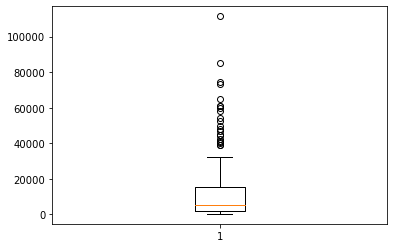

In [8]:
# Há muitos outliers de altos valores, pode influenciar na modelagem
plt.boxplot(df_dep)
plt.show()

# Tratando valores faltantes 

In [9]:
df_indep.isna().sum()

individuos_usando_internet_perc     0
expectativa_vida                    0
probabilidade_morte_criancas        0
taxa_desemprego                     5
taxa_emprego_conta_propria          5
taxa_emprego_industria              5
dias_comecar_empresa                2
taxa_impostos_trabalho              3
gasto_saude_percapita               3
gasto_governo_educacao_perc        17
dtype: int64

* Como há muitos valores faltantes para a variável de gasto de governo com educação, será feito um modelo para estimá-los

In [13]:
df_indep_gasto_governo = df_indep.copy()
df_indep_gasto_governo.dropna(subset=['gasto_governo_educacao_perc'],inplace=True) # retirando os valores faltantes da variável

In [14]:
df_indep_gasto_governo_x = df_indep_gasto_governo.drop('gasto_governo_educacao_perc', axis=1) # separando as outras variáveis
df_indep_gasto_governo_y = df_indep_gasto_governo.gasto_governo_educacao_perc # variável que deseja-se prever

In [15]:
df_indep_gasto_governo_x.fillna(-999,inplace=True) # preencher os faltantes das outras variáveis com um valor extremo, que não afetará o modelo de árvore

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_indep_gasto_governo_x,df_indep_gasto_governo_y, test_size=0.30, random_state=65)

In [17]:
# Criando um modelo de árvore para preencher os faltantes da variável de gasto de governo com educação
parametro = {'max_leaf_nodes': [4,8,16,32,64,128,256,512,1024,2048]}
clf =  tree.DecisionTreeRegressor(splitter = 'best', criterion="mae" ,random_state=42)
clf = GridSearchCV(clf, parametro,scoring='neg_mean_absolute_error', cv=10)
clf.fit(X_train,y_train)
y_predict = clf.predict(X_test)

from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, y_predict) # erro do modelo para variável é de 1,3

1.31012688593732

In [18]:
# Separando as demais variáveis para aplicar o modelo acima
df_indep_input_gasto_gov = df_indep[df_indep['gasto_governo_educacao_perc'].isna()]
df_indep_input_gasto_gov = df_indep_input_gasto_gov.drop(['gasto_governo_educacao_perc'],axis=1)
df_indep_input_gasto_gov.fillna(-999,inplace=True)

In [19]:
# Prevendo os valores faltantes
input_gasto_gov = clf.predict(df_indep_input_gasto_gov)
df_indep_input_gasto_gov['pred'] = input_gasto_gov

In [20]:
# Unindo os novos valores previstos com a base inicial
df_indep = pd.merge(df_indep, df_indep_input_gasto_gov['pred'], how='left' ,left_index=True, right_index=True)
df_indep['gasto_governo_educacao_perc'].fillna(value=df_indep.pred,inplace=True)
df_indep.drop('pred',axis=1,inplace=True)

In [22]:
df_indep.fillna(-999,inplace=True) #preechendo valores ausentes das demais variáveis

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df_indep,df_dep, test_size=.3)

In [24]:
# Criando modelo de random forest
parametros = {'max_leaf_nodes': [4,8,16,32,64]}
scoring = {'MAE': 'neg_mean_absolute_error','R2': 'r2'}

rf = GridSearchCV(
    RandomForestRegressor(n_estimators=1000,criterion = 'mae', random_state=61658),
    parametros,
    cv=5,
    scoring=scoring,
    refit = 'MAE')
rf.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mae', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=1000, n_jobs=None,
                                             oob_score=False,
                                             random_state=61658, verbose=0,
                                             warm_st

In [25]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
print(mean_absolute_error(y_test, rf.predict(X_test))) # o erro absoluto médio é de 3.399 na base de teste
print(r2_score(y_test, rf.predict(X_test))) # O R2 no teste foi de 0,72

3399.9188305536836
0.7270930988367035


In [26]:
np.std(df_dep) # o desvio-padrão da variável resposta é de 18.829

18829.524999854824

* Sobre a importância de variáveis:
    * Gasto de saúde foi a mais significativa
    * Percentual de individuos usando internet foi a segunda mais importante

In [28]:
imps = rf.best_estimator_.feature_importances_
cols = X_train.columns
order= np.argsort(imps)[::-1]

for col,imp in zip(cols[order],imps[order]):
    print(f'{col:50s} {imp:.4f}')

gasto_saude_percapita                              0.5601
individuos_usando_internet_perc                    0.1833
probabilidade_morte_criancas                       0.0692
expectativa_vida                                   0.0608
taxa_emprego_conta_propria                         0.0299
taxa_emprego_industria                             0.0257
taxa_desemprego                                    0.0230
dias_comecar_empresa                               0.0174
gasto_governo_educacao_perc                        0.0168
taxa_impostos_trabalho                             0.0139


* Plotando a relação observada acima
    * Quanto mais na diagonal superior direta esta a observação, maior o pib percapita, em que ambas as variáveis são maiores
    * Para a variável de gasto com saúde é mais visivel a relação

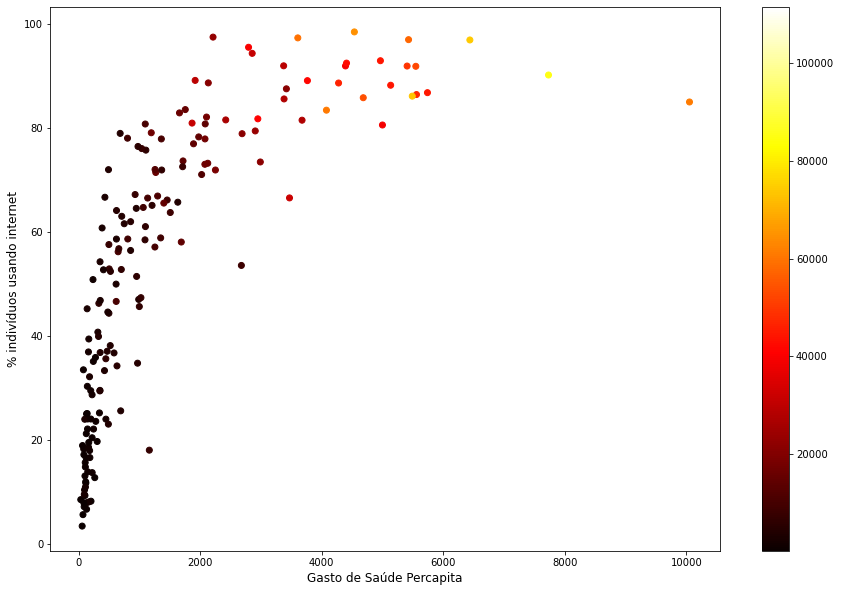

In [31]:
plt.figure(figsize=(15,10))
plt.scatter(df['gasto_saude_percapita'],df['individuos_usando_internet_perc'], c=df['pib_percapita'],cmap='hot')
plt.xlabel("Gasto de Saúde Percapita", fontsize = 12) 
plt.ylabel("% indivíduos usando internet", fontsize = 12)
plt.colorbar()
plt.show()

* Verificando os erros
    * Há certo viés do modelo de superestimar alguns valores, visto os erros negativos altos observados

In [32]:
erros = y_test - rf.predict(X_test)

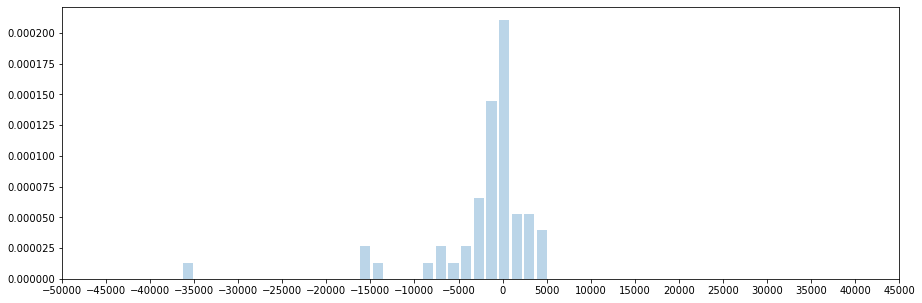

In [43]:
minimo = min(erros)
maximo = max(erros)
plt.figure(figsize=(15,5))
plt.hist(erros, bins=np.linspace(minimo,maximo,30), rwidth=.8, alpha=.3, density=True, color='C0')
plt.xticks(np.arange(-50000, 50000, step=5000)) 
plt.show()

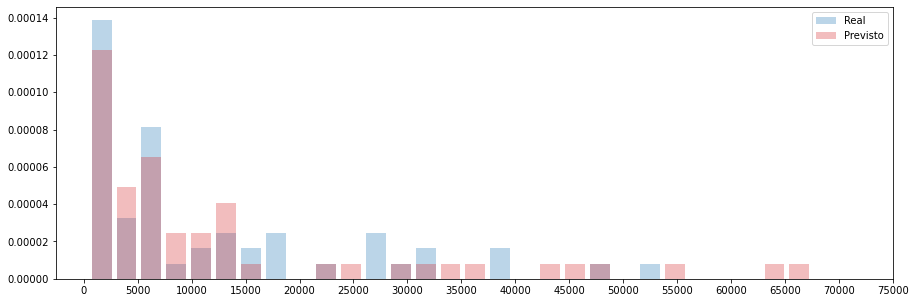

In [50]:
minimo = min(y_test.min(),rf.predict(X_test).min())
maximo = max(y_test.max(),rf.predict(X_test).max())

plt.figure(figsize=(15,5))
plt.hist(y_test, bins=np.linspace(minimo,maximo,30), rwidth=.8, alpha=.3, density=True, color='C0', label="Real")
plt.hist(rf.predict(X_test), bins=np.linspace(minimo,maximo,30), rwidth=.8, alpha=.3, density=True, color='C3', label="Previsto")
plt.xticks(np.arange(0, 80000, step=5000))
plt.legend()
plt.show()